# Train the controller with minimum jerk assumption

BUGMAN Feb 17 2022

In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

EMG_mapping_Lr = 10
Dynamic_system_Lr = 5
Lr = 1e-2
NN_ratio = 0.2
stride = 1
batch_size = 512

INPUT_FS = 1000
OUTPUT_FS = 60

muscleType = 'bilinear'
numDoF = 4
EMG_Channel_Count = 8

import numpy as np
np.set_printoptions(linewidth=200, suppress=True)
torch.set_printoptions(linewidth=300, sci_mode=False)

import sys
import os

# Add to the path this folder and its parent to find the other modules
sys.path.append(os.path.dirname(os.path.abspath('')))

from torch.utils.data import DataLoader
from OnlineLearning.Offline_EMG_Goniometer_DataLoader import Offline_EMG_Goniometer_DataLoader

Using device: cpu


# Load Dataset from Pickle files

In [3]:
# FOLDER_PATH = '/home/haptix/UE AMI Clinical Work/Patient Data/P7 - 453/P7_0325_2024/Data Recording/PROCESSED/pkl/'
FOLDER_PATH = '/Users/jg/projects/biomech/DataGen/biomech_Shadmehr_Opt/data/P7_0326_2024/MinJerk/'
FILE_NAMES = []
for path in sorted(os.listdir(FOLDER_PATH)):
    if path.endswith('.pkl') and os.path.isfile(os.path.join(FOLDER_PATH, path)):
        FILE_NAMES.append(path) # this should end in .pkl

print(FILE_NAMES)

['fingersFlex.pkl', 'handCloseOpen.pkl', 'handClosewristFlex.pkl', 'indexFlex.pkl', 'mrpFlex.pkl', 'pinchClose.pkl', 'pointingClose.pkl', 'thumbFlex.pkl', 'wristFlex.pkl', 'wristFlexHandOpen.pkl']


In [3]:
def jointAdjustment(jointNames, jointAngles, splits, scaling=1, handedness='L'):
    if handedness == 'R':
        jointRoMs = {'thumbYPos': [0, 75], 'thumbPPos': [0, 100], 'indexPos': [0, 90], 'mrpPos': [0, 90], 'wristRot': [-120, 175], 'wristFlex': [-55, 55], 'humPos': [-95, 95], 'elbowPos': [0, 135]}
    elif handedness == 'L':
        jointRoMs = {'thumbYPos': [0, 75], 'thumbPPos': [0, 100], 'indexPos': [0, 90], 'mrpPos': [0, 90], 'wristRot': [-175, 120], 'wristFlex': [-55, 55], 'humPos': [-95, 95], 'elbowPos': [0, 135]}
    else:
        raise ValueError(f'Invalid handedness {handedness}')
    
    numJoints = len(jointNames)
    assert numJoints == jointAngles.shape[1], f'Different number of joints names and angles given ({numJoints} names and {jointAngles.shape[1]} joints)'
    
    returnAnglesRaw = np.zeros_like(jointAngles)
    for joint in range(numJoints):
        angleRaw = jointAngles[:, joint]
        jointRoM = jointRoMs[jointNames[joint]]
        rom = np.deg2rad(sum([abs(i) for i in jointRoM]))

        returnAnglesRaw[:, joint] = angleRaw*scaling/rom

    returnAngles = [returnAnglesRaw[splits[i]:splits[i + 1], :] for i in range(len(splits) - 1)]
    returnAngles = [[np.array(j) for j in i] for i in returnAngles]

    return returnAngles

    # velsRaw = np.diff(returnAnglesRaw, axis=0)*OUTPUT_FS
    # velsRaw = np.concatenate((np.zeros((1, numJoints)), velsRaw))

    # meanVels = np.mean(velsRaw, axis=0)
    # stdVels = np.std(velsRaw, axis=0)
    # thresh = np.multiply(np.ones(stdVels.shape[0]), stdVels)
    # jointMoving = (np.abs(velsRaw - meanVels) > thresh).astype(float)

    # returnAngles = [returnAnglesRaw[splits[i]:splits[i + 1], :] for i in range(len(splits) - 1)]
    # returnVels = [jointMoving[splits[i]:splits[i + 1], :] for i in range(len(splits) - 1)]

    # for i in range(len(returnAngles)):
    #     returnAngles[i] = [np.array(j) for j in returnAngles[i]]
    #     returnVels[i] = [np.array(j) for j in returnVels[i]]

    # return returnAngles, returnVels

In [8]:
import pickle

# default standin here, fill in appropriately
jointsNames = []
jointLabels = []

jointNames = ['thumbPPos', 'indexPos', 'mrpPos', 'wristFlex']
# ['free1__thumb_index_MRP.pkl', 'free2__flex.pkl', 'pickPlace1__thumb_index_MRP.pkl', 'test1__thumb.pkl', 'test21__thumb.pkl', 'test22__index.pkl', 'test23__MRP.pkl', 'test24__flex.pkl', 'test2__index.pkl', 'test3__MRP.pkl', 'test4__flex.pkl']
# jointLabels = [[1, 1, 1, 0],
#                [0, 0, 0, 1],
#                [1, 1, 1, 0],
#                [1, 0, 0, 0],
#                [1, 0, 0, 0],
#                [0, 1, 0, 0],
#                [0, 0, 1, 0],
#                [0, 0, 0, 1],
#                [0, 1, 0, 0],
#                [0, 0, 1, 0],
#                [0, 0, 0, 1]]
# ['fingersFlex.pkl', 'handCloseOpen.pkl', 'handClosewristFlex.pkl', 'indexFlex.pkl', 'mrpFlex.pkl', 'pinchClose.pkl', 'pointingClose.pkl', 'thumbFlex.pkl', 'wristFlex.pkl', 'wristFlexHandOpen.pkl']
jointLabels = [[0, 1, 1, 0],
               [1, 1, 1, 0],
               [1, 1, 1, 1],
               [0, 1, 0, 0],
               [0, 0, 1, 0],
               [1, 1, 0, 0],
               [1, 0, 1, 0],
               [1, 0, 0, 0],
               [0, 0, 0, 1],
               [1, 1, 1, 1]]

file_data_loader = Offline_EMG_Goniometer_DataLoader()

processed_EMG_list = []
processed_Angle_list = []
processed_Joint_list = []
splits = [0]

for i in range(len(FILE_NAMES)):
    FILE_NAME = FILE_NAMES[i]
    print(f'{FILE_NAME}')
    # FILE_NAME = FILE_NAME if FILE_NAME.endswith(".pkl") else FILE_NAME + ".pkl"
    fullFile = FOLDER_PATH + FILE_NAME

    with open(fullFile, "rb") as f:
        loaded_data = pickle.load(f)

    # print(len(loaded_data), len(loaded_data[0]), len(loaded_data[1]), len(loaded_data[2]))
    thisEMG = loaded_data[0][0]
    thisAngles = np.asarray(loaded_data[1])[:, :numDoF]
    # movedJoints = np.where(np.count_nonzero(thisAngles, axis=0) > 0, 1, 0)
    movedJoints = jointLabels[i][:numDoF]
    jointLabels.append(list(movedJoints))

    numTimePoints = len(thisEMG)
    
    # thisEMG = Offline_EMG_Processor.extract_synergies(thisEMG, path='/home/haptix/UE AMI Clinical Work/P3 - 152/P3_0725_2022/JS-0725_2022_newSynergyMat.csv')
    # maxVals = np.max(np.abs(np.deg2rad(thisAngles)), axis=0)
    # thisAngles = [np.divide(np.array(np.deg2rad(timeStep)), maxVals) for timeStep in thisAngles] # numTimestep len 1D list of nDof arrays
    thisAngles = [np.array(timeStep) for timeStep in thisAngles] # numTimestep len 1D list of nDof arrays
    thisEMG = [np.array(timeStep) for timeStep in thisEMG]

    processed_EMG_list.append(thisEMG)
    processed_Angle_list.append(thisAngles)

    # movedJoints = jointLabels[i][:numDoF]
    processed_Joint_list.append([np.array(movedJoints) for _ in range(numTimePoints)])

    splits.append(splits[-1] + numTimePoints)

# processed_Angle_list = jointAdjustment(jointNames[:numDoF], np.concatenate(processed_Angle_list, axis=0), splits, scaling=1)
print(f'Joint Balance: {np.sum(jointLabels, axis=0)/len(jointLabels)}\n')

fingersFlex.pkl
handCloseOpen.pkl
handClosewristFlex.pkl
indexFlex.pkl
mrpFlex.pkl
pinchClose.pkl
pointingClose.pkl
thumbFlex.pkl
wristFlex.pkl
wristFlexHandOpen.pkl
Joint Balance: [0.6 0.6 0.6 0.3]



# Plot the data

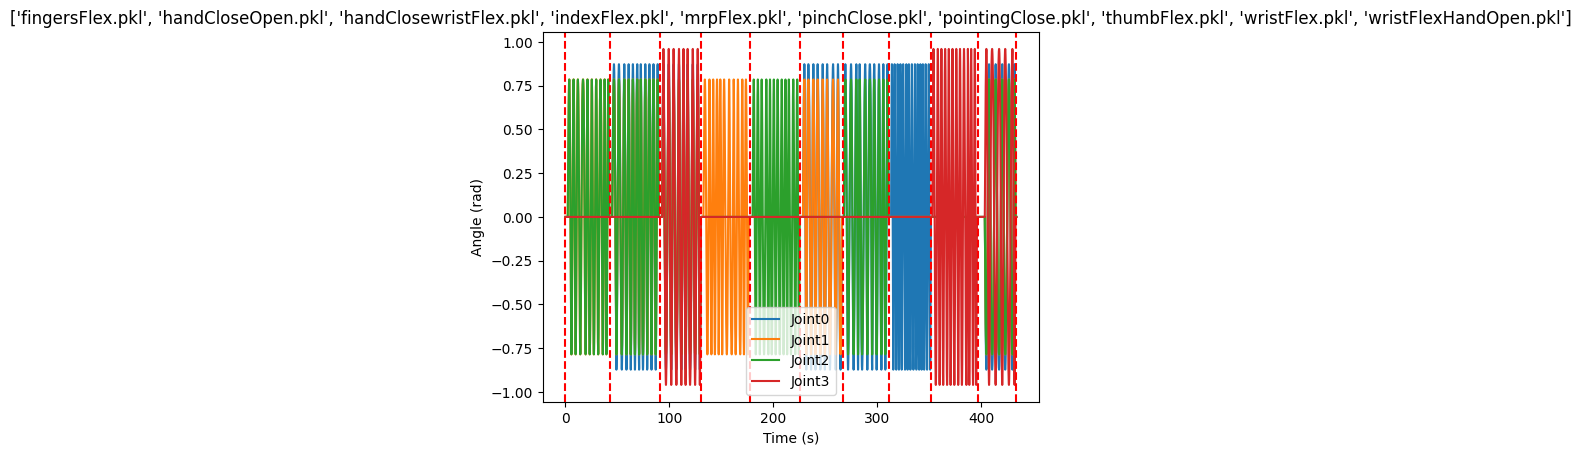

In [9]:
# %matplotlib qt
%matplotlib inline

import matplotlib.pyplot as plt
plt.figure(1)

plot_Angle = []
for i in range(0, len(processed_Angle_list)):
    plot_Angle += processed_Angle_list[i]
    
trajs = []
for i in range(numDoF):
    trajs.append(np.array(plot_Angle)[:, i])
t_goni = np.array(np.linspace(0, len(trajs[0]), len(trajs[0])))/OUTPUT_FS

#Plot minimum jerk trajectory
t = np.linspace(0, len(plot_Angle)/OUTPUT_FS, len(plot_Angle))
t = (np.array(t) + 130)/OUTPUT_FS

for i in range(numDoF):
    plt.plot(t_goni, trajs[i], label=f'Joint{i}')

for split in splits:
    plt.axvline(x=split/OUTPUT_FS, color='red', linestyle='--')

# plt.title("Joint Trajectories by Minimum Jerk Trajectory Generator")
plt.title(FILE_NAMES)
plt.xlabel("Time (s)")
plt.ylabel("Angle (rad)")
plt.legend()
plt.show()

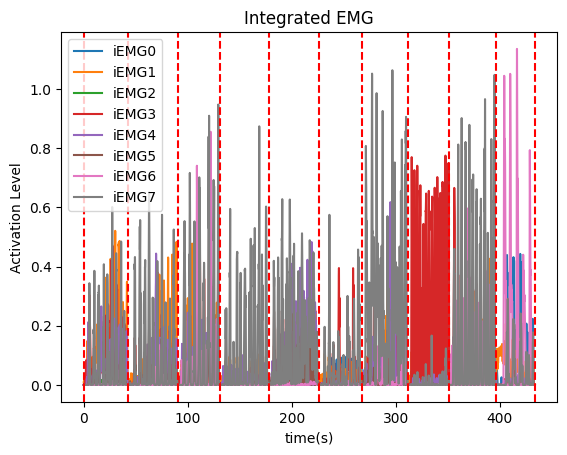

In [10]:
# %matplotlib qt
%matplotlib inline

plt.close(1); plt.figure(1)

input_EMG = []
for i in range(0, len(processed_EMG_list)):
    input_EMG += processed_EMG_list[i]

EMGs = []
for i in range(EMG_Channel_Count):
    EMGs.append(np.array(input_EMG)[:, i])

t = np.linspace(0, len(input_EMG)/OUTPUT_FS, len(input_EMG))
t = (np.array(t) + 130)/OUTPUT_FS
t_EMG = np.array(np.linspace(0, len(EMGs[0]), len(EMGs[0])))/OUTPUT_FS

for i in range(EMG_Channel_Count):
    plt.plot(t_EMG, EMGs[i], label=f'iEMG{i}')

for split in splits:
    plt.axvline(x=split/OUTPUT_FS, color='red', linestyle='--')

plt.title("Integrated EMG")
plt.xlabel("time(s)")
plt.ylabel("Activation Level")
plt.legend()
plt.show()

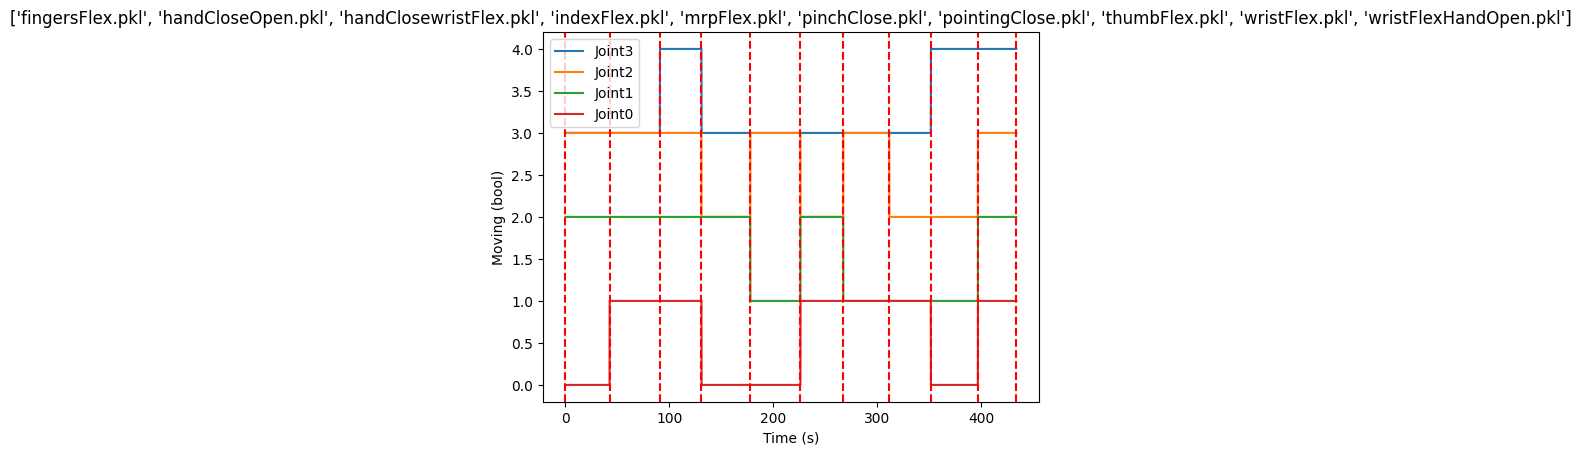

In [14]:
# %matplotlib qt
%matplotlib inline

jointMoving = []
for i in range(0, len(processed_Joint_list)):
    jointMoving += processed_Joint_list[i]

movingBools = []
for i in range(numDoF):
    movingBools.append(np.array(jointMoving)[:, i])

t_goni = np.array(np.linspace(0, len(movingBools[0]), len(movingBools[0])))/OUTPUT_FS
for i in range(numDoF - 1, -1, -1):
    plt.plot(t_goni, movingBools[i] + i, label=f'Joint{i}')

for split in splits:
    plt.axvline(x=split/OUTPUT_FS, color='red', linestyle='--')

# plt.title("Joint Trajectories by Minimum Jerk Trajectory Generator")
plt.title(FILE_NAMES)
plt.xlabel("Time (s)")
plt.ylabel("Moving (bool)")
plt.legend()
plt.show()

In [15]:
from OnlineLearning.Offline_Dataset import Offline_Dataset

data_set = Offline_Dataset(processed_EMG_list, processed_Angle_list, processed_Joint_list, data_piece_length=120, stride=stride)
numTrainingPoints = len(data_set)
print(f'Number of data points: {numTrainingPoints}')

trainCount = int(0.8*numTrainingPoints)
testCount = numTrainingPoints - trainCount
train_dataset, test_dataset = torch.utils.data.random_split(data_set, (trainCount, testCount))

trainDataLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, persistent_workers=True, drop_last=True, pin_memory=True)
testDataLoader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, persistent_workers=False, drop_last=True, pin_memory=True)

data_loaders = {'train': trainDataLoader,
              'test': testDataLoader}

print(f'Train batches: {len(trainDataLoader)}')
print(f'Test batches: {len(testDataLoader)}')

Number of data points: 24837
Train batches: 38
Test batches: 9


In [16]:
# checking the dataloader
a = next(iter(trainDataLoader))

In [17]:
a


[[tensor([[    0.0000,     0.0000,     0.0000,  ...,     0.0000,     0.0000,     0.0000],
          [    0.0002,     0.0175,     0.0008,  ...,     0.0551,     0.0000,     0.0399],
          [    0.0939,     0.0075,     0.0000,  ...,     0.0393,     0.0000,     0.1588],
          ...,
          [    0.0000,     0.0398,     0.0000,  ...,     0.0000,     0.0000,     0.0000],
          [    0.0000,     0.0736,     0.0370,  ...,     0.0008,     0.0004,     0.0066],
          [    0.0000,     0.0846,     0.0006,  ...,     0.0000,     0.0605,     0.0000]], dtype=torch.float64),
  tensor([[    0.0000,     0.0000,     0.0000,  ...,     0.0000,     0.0000,     0.0000],
          [    0.0002,     0.0182,     0.0011,  ...,     0.0507,     0.0000,     0.0380],
          [    0.0977,     0.0075,     0.0000,  ...,     0.0423,     0.0000,     0.1703],
          ...,
          [    0.0000,     0.0393,     0.0000,  ...,     0.0000,     0.0000,     0.0000],
          [    0.0000,     0.0733,     0.0364, 

# Train the Model

In [9]:
import gc

torch.cuda.empty_cache()
gc.collect()

4880

In [10]:
%load_ext autoreload
%autoreload 2

# from Dynamics2.upperLimbModel import upperExtremityModel # use the new version of the model, the generic one
from Dynamics2.upperLimbModel_copy import upperExtremityModel

print(f'Using {torch.get_num_threads()} CPU threads')
system_dynamic_model = upperExtremityModel(muscleType=muscleType, numDoF=numDoF, device=device, EMG_Channel_Count=EMG_Channel_Count, Dynamic_Lr=Dynamic_system_Lr, EMG_mat_Lr=EMG_mapping_Lr, NN_ratio=NN_ratio)

print(f'Number of model parameters: {system_dynamic_model.count_params()}')

# print(system_dynamic_model)

# print initial values, for checking
# for name, param in system_dynamic_model.named_parameters():
#     if param.requires_grad:
#         print(name, param.data)

Using 16 CPU threads
Number of model parameters: 158896


In [ ]:
# Initial condition modification
theta = torch.linspace(1, 2, steps=10)
# omega = 2*torch.rand_like(theta) - 1
# omega = torch.linspace(0, 1, steps=100)
omega = torch.ones_like(theta)
alphas = torch.ones_like(theta) # torch.rand_like(theta)

# plt.figure(1)
# plt.clf()

lMs = []
for i in range(2):
    testMusc = system_dynamic_model.JointDict[0].init_muscles[i]

    # lM_eq, storage, idx = testMusc.findInitlM(theta, omega, alphas, storing=True)
    lM_eq = testMusc.newtonInit(theta, omega, alphas, maxIters=10000)
    # print(f'Muscle equilibrium length {i}: {lM_eq}')
    lMs.append(lM_eq/testMusc.lM_opt)

    # plt.plot(theta, storage["dlMT_dt"][:, idx], label=f'musc{i} dlMT_dt')
    # plt.plot(theta, storage["fiberVel"][:, idx], label=f'musc{i} fiberVel')
    # plt.plot(theta, storage['fV_inv'], label='unnormalized')
    # plt.legend()

    # plt.figure()
    # plt.clf()
    # numPlots = len(storage)
    # lM = storage.pop('lM')
    # for idx, (key, val) in enumerate(storage.items()):
    #     plt.subplot(numPlots//2, 2, idx + 1)
    #     plt.plot(lM.transpose(0, 1), val.transpose(0, 1))
    #     # plt.plot(theta, val)
    #     plt.ylabel(key)
    # plt.suptitle(f'Muscle {i} curves')
    # plt.show()
# testMusc.plotMuscleCurves()

# plt.figure(2)
# plt.clf()
# plt.plot(theta, lMs[0], label='Muscle 0')
# plt.plot(theta, lMs[1], label='Muscle 1')
# plt.xlabel('Theta')
# plt.ylabel('lM_norm')
# plt.title(f'lM Initital Conditions')
# plt.legend()
# plt.show()

In [11]:
import torch.optim as optim
# from Upper_Trainer import Offline_Trainer
from Upper_Trainer_copy import Offline_Trainer

model_save_path = "./minJerkModel_synergyNoCost.tar"

system_dynamic_model.train() # put the model in train mode
trainer = Offline_Trainer(system_dynamic_model, model_save_path, device, early_stopping=3, delay=0.03, clip=10, EMG_mapping_flexible=EMG_mapping_Lr)
optimizer = optim.Adam(system_dynamic_model.parameters(), lr=Lr, amsgrad=False)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, cooldown=0)

In [59]:
# train!
trainer.train(data_loaders, optimizer, scheduler, init_model_path='minJerkModel_synergyNoCost.tar', epoch_num=1000, twoStep=True)
# trainer.train(data_loaders=data_loaders, optimizer=optimizer, scheduler=scheduler, epoch_num=1000, twoStep=True)


*********************************

Training epoch 0...
	Epoch 000, Step [0004/37], Mean Loss: 0.887254
		Loss Classifier: 0.6996737718582153
		Loss 0 = tensor(0.0734, device='cuda:0', grad_fn=<SelectBackward0>)
		Loss 1 = tensor(0.0446, device='cuda:0', grad_fn=<SelectBackward0>)
		Loss 2 = tensor(0.0462, device='cuda:0', grad_fn=<SelectBackward0>)
		Loss 3 = tensor(0.0203, device='cuda:0', grad_fn=<SelectBackward0>)

	Epoch 000, Step [0009/37], Mean Loss: 0.885852
		Loss Classifier: 0.700110673904419
		Loss 0 = tensor(0.0757, device='cuda:0', grad_fn=<SelectBackward0>)
		Loss 1 = tensor(0.0463, device='cuda:0', grad_fn=<SelectBackward0>)
		Loss 2 = tensor(0.0494, device='cuda:0', grad_fn=<SelectBackward0>)
		Loss 3 = tensor(0.0243, device='cuda:0', grad_fn=<SelectBackward0>)

	Epoch 000, Step [0014/37], Mean Loss: 0.887759
		Loss Classifier: 0.701124906539917
		Loss 0 = tensor(0.0745, device='cuda:0', grad_fn=<SelectBackward0>)
		Loss 1 = tensor(0.0437, device='cuda:0', grad_fn=<Sele

In [ ]:
# for name, param in system_dynamic_model.named_parameters():
#     if param.requires_grad and not (name.__contains__('compensational_nns') or name.__contains__('recognitionLayer') or name.__contains__('activationLayer')):
#         print(name, param.data)
system_dynamic_model.print_params()

# Verify the model

In [ ]:
# This block is only to reload things
import pickle

FILE_NAMES = ['P1_0307_2022_elbow.pkl', 'P1_0307_2022_finger.pkl', 'P1_0307_2022_thumb.pkl', 'P1_0307_2022_index.pkl']

file_data_loader = Offline_EMG_Goniometer_DataLoader()

processed_EMG_list = []
processed_Angle_list = []

for FILE_NAME in FILE_NAMES:
    print(FILE_NAME)
    # FOLDER_PATH = '/home/haptix/haptix/Upper Extremity Models/Upper Extremity Shadmehr/' + FILE_NAME
    FOLDER_PATH = '/home/haptix/UE AMI Clinical Work/P1 - 729/P1_0307_2022/MinJerk Pickle/' + FILE_NAME

    with open(FOLDER_PATH, "rb") as f:
        loaded_data = pickle.load(f)

    processed_EMG_list.append(loaded_data[0])
    processed_Angle_list.append(loaded_data[1])

In [15]:
model_save_path = "./minJerkModel_synergyNoCost.tar"
# model_save_path = '/home/haptix/UE AMI Clinical Work/P3 - 152/P3_0726_2022/Models/5DoF_model_lambda2.tar'
if True:
    system_dynamic_model.to(device)
    checkpoint = torch.load(model_save_path)
    # print(checkpoint['model_state_dict'])
    system_dynamic_model.load_state_dict(checkpoint['model_state_dict'])
system_dynamic_model.eval()

upperExtremityModel(
  (JointDict): ModuleList(
    (0-3): 4 x Joint_1dof(
      (K0s): ParameterList(
          (0): Parameter containing: [torch.float32 of size 1 (cuda:0)]
          (1): Parameter containing: [torch.float32 of size 1 (cuda:0)]
      )
      (K1s): ParameterList(
          (0): Parameter containing: [torch.float32 of size 1 (cuda:0)]
          (1): Parameter containing: [torch.float32 of size 1 (cuda:0)]
      )
      (L0s): ParameterList(
          (0): Parameter containing: [torch.float32 of size 1 (cuda:0)]
          (1): Parameter containing: [torch.float32 of size 1 (cuda:0)]
      )
      (L1s): ParameterList(
          (0): Parameter containing: [torch.float32 of size 1 (cuda:0)]
          (1): Parameter containing: [torch.float32 of size 1 (cuda:0)]
      )
      (Ms): ParameterList(
          (0): Parameter containing: [torch.float32 of size 1 (cuda:0)]
          (1): Parameter containing: [torch.float32 of size 1 (cuda:0)]
      )
      (As): ParameterList(

In [16]:
ss = torch.tensor([[0]*numDoF*system_dynamic_model.numStates], dtype=torch.float, device=device)

all_outs = [[] for _ in range(numDoF)]
preds = [[] for _ in range(numDoF)]
alphas = [[] for _ in range(numDoF)]

with torch.no_grad():
    # Run the model simulation
    for e in input_EMG:
        input = torch.FloatTensor(np.array([e])).to(device)
        w, ss, probs, activation = system_dynamic_model(ss, input, dt=0.0166667)

        for i in range(numDoF):
            preds[i].append(probs[:, i].detach().cpu().numpy())
            all_outs[i].append((w[:, i]).detach().cpu().numpy())
            alphas[i].append(activation[:, i].detach().cpu().numpy())

    for i in range(numDoF):
        all_outs[i] = np.array(all_outs[i]).T[0]
        preds[i] = np.array(preds[i]).T[0]
        alphas[i] = np.array(alphas[i]).T[0]

In [ ]:
# Save the model output
import pandas as pd
modelType = 'noNN_equalRoM_residual_longer2'
jointLabels = np.concatenate(processed_Joint_list)
dataToSave = np.hstack((plot_Angle, np.asarray(all_outs + preds).T, jointLabels))
colNames = ['ref' + str(i) for i in range(numDoF)] + ['pos' + str(i) for i in range(numDoF)] + ['pred' + str(i) for i in range(numDoF)] + ['label' + str(i) for i in range(numDoF)]

df = pd.DataFrame(data=dataToSave, columns=colNames)
# df.to_csv('5DoFModelResults_' + modelType + '.csv', index=False)

In [17]:
%matplotlib qt
# %matplotlib inline

t_goni = np.array(np.linspace(0, len(all_outs[0]), len(all_outs[0])))/60
fig, axs = plt.subplots(numDoF, squeeze=False)
fig.suptitle('Trained Model Performance')

for i in range(numDoF):
    mus = FILE_NAMES[i]
    axs[i][0].plot(t_goni, all_outs[i], label=f'Model{i}')
    axs[i][0].plot(t_goni, np.array(plot_Angle)[:, i], label=f'MinJerk{i}')
    axs[i][0].plot(t_goni, preds[i], label=f'Pred{i}')
    axs[i][0].set_ylabel("Angle (rad)")
    
axs[numDoF - 1][0].set_xlabel("Time (s)")
# axs[numDoF - 1][0].legend()

plt.show()

In [ ]:
# Plots and calculations
%matplotlib qt
# %matplotlib inline

t_goni = np.array(np.linspace(0, len(all_outs[0]), len(all_outs[0])))/60
fig, axs = plt.subplots(numDoF)
# plt.figure(0)
# plt.title("Trained Model Performance")
fig.suptitle('Trained Model Performance', fontsize=20, y=0.95, x=0.5)
# fig.suptitle('Model Output in Blue; Reference Trajectory in Orange', fontsize=16)

plotAngles = np.array(plot_Angle)
mse = (np.square(all_outs - plotAngles.T)).mean(axis=1)
outs = (np.array(all_outs).T - np.array(all_outs).T.mean(axis=0)) / np.array(all_outs).T.std(axis=0)
angs = (plotAngles - plotAngles.mean(axis=0)) / plotAngles.std(axis=0)
pearson_r = np.dot(outs.T, angs) / outs.shape[0]

residuals = np.sum(np.square(all_outs - plotAngles.T), axis=1)
tss = np.sum(np.square(plotAngles.T - np.mean(plotAngles.T, axis=1)[:, None]), axis=1)
R = 1 - residuals/tss
print(f'R: {R}')

joints =  ['Thumb', 'Index', 'Digits', 'Wrist rotate', 'Wrist flex']
for i in range(numDoF):
    mus = FILE_NAMES[i]
    # plt.plot(t_goni, all_outs[i], label=f'Model Output {i}')
    # plt.plot(t_goni, np.array(plot_Angle)[:, i], label=f'Minimum Jerk {i}')
    axs[i].plot(t_goni, all_outs[i], label=f'Model Output {i}', linewidth=2.5)
    axs[i].plot(t_goni, np.array(plot_Angle)[:, i], label=f'Minimum Jerk {i}', linewidth=2)
    axs[i].set_ylabel(joints[i], fontsize=12)
    axs[i].autoscale(enable=True, axis='x', tight=True)

    # plt.plot(t_goni, preds[i], label=f'Predictions {i}')
    # plt.plot(t_goni, all_outs[i], label=f'Model Output {str(i)}')
    # plt.plot(t_goni, np.array(plot_Angle)[:, i], label=f'Minimum Jerk {str(i)}')

axs[numDoF - 1].set_xlabel('Time (s)', fontsize=12)
axs[0].set_title('Model Output in Blue; Reference Trajectory in Orange', fontsize=16)
print(f'Before mse: {mse}')
print(f'Before r:\n{pearson_r}')
# plt.tight_layout()

plt.show()

fig2, axs2 = plt.subplots(numDoF)
fig2.suptitle('Prediction of Intent to Move', fontsize=20, y=0.95, x=0.5)

jointLabels = np.concatenate(processed_Joint_list)
# cutoffs = np.array([0.6, 0.7, 0.7, 0.45, 0.45]) # JM 09-28, 09-28
# cutoffs = np.array([0.5, 0.5, 0.3, 0.5]) # JM 09-28, 09-28
# cutoffs = np.array([0.9, 0.9, 0.9, 0.9, 0.9])
cutoffs = np.array([0.7, 0.7, 0.7, 0.7])

joints =  ['ThumbP', 'ThumbY', 'Index', 'Digits', 'Wrist flex']
smoothedArr = np.zeros((numDoF, len(preds[0])))
for i in range(numDoF):
    x = 10
    smoothedArr[i, :] = np.convolve(preds[i], np.ones(x), 'same')/x
    # axs2[i].plot(t_goni, preds[i], 'b--', label=f'Prediction {i}', linewidth=1)
    axs2[i].plot(t_goni, smoothedArr[i, :], 'b--', label=f'Prediction {i}', linewidth=1.5)
    # axs2[i].plot(t_goni, cutoffs[i]*np.ones_like(preds[1]), 'r-.', label=f'Prediction {i}', linewidth=1)
    axs2[i].plot(t_goni, smoothedArr[i, :] > cutoffs[i], 'darkgreen', label=f'Prediction {i}', linewidth=2.5)
    axs2[i].plot(t_goni, jointLabels[:, i], label=f'Prediction {i}', linewidth=1.5)
    axs2[i].set_ylabel(joints[i], fontsize=12)
    axs2[i].autoscale(enable=True, axis='x', tight=True)

axs2[numDoF - 1].set_xlabel('Time (s)', fontsize=12)
axs2[0].set_title('Predictions in Blue, Cutoffs in Red, Thresholded Predictions in Green', fontsize=16)

# plt.tight_layout()

plt.show()
newOuts = np.where(smoothedArr > np.repeat(cutoffs[:, None], repeats=smoothedArr.shape[1], axis=1), np.array(all_outs), 0)
mse = (np.square(newOuts - plotAngles.T)).mean(axis=1)
outs = (np.array(newOuts).T - np.array(newOuts).T.mean(axis=0)) / np.array(newOuts).T.std(axis=0)
angs = (plotAngles - plotAngles.mean(axis=0)) / plotAngles.std(axis=0)
pearson_r = np.dot(outs.T, angs) / outs.shape[0]

print(f'After mse: {mse}')
print(f'After r:\n{pearson_r}')
jointLabels = np.concatenate(processed_Joint_list)
correctLabel = np.logical_and(jointLabels.astype(bool), newOuts.T.astype(bool))
numRight = np.count_nonzero(correctLabel, axis=0)
numTrues = np.count_nonzero(jointLabels, axis=0)
print(f'Classification accuracy:\n{np.divide(numRight, numTrues)}')

residuals = np.sum(np.square(newOuts - plotAngles.T), axis=1)
tss = np.sum(np.square(plotAngles.T - np.mean(plotAngles.T, axis=1)[:, None]), axis=1)
R = 1 - residuals/tss
print(R)


fig3, axs3 = plt.subplots(numDoF)
# plt.figure(0)
# plt.title("Trained Model Performance")
fig3.suptitle('Model Performance after Thresholding', fontsize=20, y=0.95, x=0.5)
# fig.suptitle('Model Output in Blue; Reference Trajectory in Orange', fontsize=16)

joints =  ['ThumbP', 'ThumbY', 'Index', 'Digits', 'Wrist flex']
for i in range(numDoF):
    mus = FILE_NAMES[i]
    # plt.plot(t_goni, all_outs[i], label=f'Model Output {i}')
    # plt.plot(t_goni, np.array(plot_Angle)[:, i], label=f'Minimum Jerk {i}')
    axs3[i].plot(t_goni, newOuts[i], label=f'Model Output {i}', linewidth=2.5)
    axs3[i].plot(t_goni, np.array(plot_Angle)[:, i], label=f'Minimum Jerk {i}', linewidth=2)
    axs3[i].set_ylabel(joints[i], fontsize=12)
    axs3[i].autoscale(enable=True, axis='x', tight=True)

    # plt.plot(t_goni, preds[i], label=f'Predictions {i}')
    # plt.plot(t_goni, all_outs[i], label=f'Model Output {str(i)}')
    # plt.plot(t_goni, np.array(plot_Angle)[:, i], label=f'Minimum Jerk {str(i)}')

axs3[numDoF - 1].set_xlabel('Time (s)', fontsize=12)
axs3[0].set_title('Model Output in Blue; Reference Trajectory in Orange', fontsize=16)
# plt.tight_layout()

plt.show()

# Save the model

In [ ]:
torch.save({'model_state_dict': system_dynamic_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()},
            model_save_path)